# Predicting House Sale Prices with Linear Regression

## Introduction

We will start by writing a draft of 3 functions that we will update along the way.
The functions are:
1. transform_features: to do feature engineering.
2. select_features: to allow us to experiment with different feature combinations.
3. train_and_test(): to quickly train and test different iterations of the model.

In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

df = pd.read_csv('AmesHousing.tsv', sep='\t')

In [99]:
def transform_features(df):
    return df

In [100]:
def select_features(df):
    return df[['Gr Liv Area', 'SalePrice']]

In [101]:
def train_and_test(df):
    train = df[:1460]
    test = df[1460:]
    
    numeric_train = train.select_dtypes(include=['float', 'integer'])
    numeric_test = test.select_dtypes(include=['float', 'integer'])
    
    features = numeric_train.columns.drop('SalePrice')
    target = 'SalePrice'
    lr = linear_model.LinearRegression()
    lr.fit(train[features], train[target])
    predictions = lr.predict(test[features])
    mse = mean_squared_error(test[target], predictions)
    rmse = np.sqrt(mse)
    
    return rmse
    

In [102]:
transformed_df = transform_features(df)
filtered_df = select_features(transformed_df)
rmse = train_and_test(filtered_df)

rmse

57088.25161263909

## Feature Engineering

Next we will remove features with more than 5% missing values, and transform other features into proper format.

Let's start by removing features with more than 5% missing values:

In [103]:
num_missing = df.isnull().sum()
missing_cols = num_missing[num_missing > len(df)*0.05]
df = df.drop(missing_cols.index, axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 71 columns):
Order              2930 non-null int64
PID                2930 non-null int64
MS SubClass        2930 non-null int64
MS Zoning          2930 non-null object
Lot Area           2930 non-null int64
Street             2930 non-null object
Lot Shape          2930 non-null object
Land Contour       2930 non-null object
Utilities          2930 non-null object
Lot Config         2930 non-null object
Land Slope         2930 non-null object
Neighborhood       2930 non-null object
Condition 1        2930 non-null object
Condition 2        2930 non-null object
Bldg Type          2930 non-null object
House Style        2930 non-null object
Overall Qual       2930 non-null int64
Overall Cond       2930 non-null int64
Year Built         2930 non-null int64
Year Remod/Add     2930 non-null int64
Roof Style         2930 non-null object
Roof Matl          2930 non-null object
Exterior 1st       29

For the remaining numerical columns, we will fill the missing values using the most popular value for that column.

In [104]:
num_missing = df.select_dtypes(include=['float', 'int']).isnull().sum()
cols_to_fix = num_missing[num_missing > 0]
cols_to_fix

Mas Vnr Area      23
BsmtFin SF 1       1
BsmtFin SF 2       1
Bsmt Unf SF        1
Total Bsmt SF      1
Bsmt Full Bath     2
Bsmt Half Bath     2
Garage Cars        1
Garage Area        1
dtype: int64

In [105]:
mode_values_dict = df[cols_to_fix.index].mode().to_dict(orient='records')[0]
mode_values_dict

{'Bsmt Full Bath': 0.0,
 'Bsmt Half Bath': 0.0,
 'Bsmt Unf SF': 0.0,
 'BsmtFin SF 1': 0.0,
 'BsmtFin SF 2': 0.0,
 'Garage Area': 0.0,
 'Garage Cars': 2.0,
 'Mas Vnr Area': 0.0,
 'Total Bsmt SF': 0.0}

In [106]:
df = df.fillna(mode_values_dict)
#verifiy that all numeric columns contain zero missing values
num_missing.isnull().sum()

0

For now, we will also drop text columns with any missing values.

In [107]:
text_cols_count = df.select_dtypes(include=['object']).isnull().sum()
cols_to_remove = text_cols_count[text_cols_count > 0]
df = df.drop(cols_to_remove.index, axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 64 columns):
Order              2930 non-null int64
PID                2930 non-null int64
MS SubClass        2930 non-null int64
MS Zoning          2930 non-null object
Lot Area           2930 non-null int64
Street             2930 non-null object
Lot Shape          2930 non-null object
Land Contour       2930 non-null object
Utilities          2930 non-null object
Lot Config         2930 non-null object
Land Slope         2930 non-null object
Neighborhood       2930 non-null object
Condition 1        2930 non-null object
Condition 2        2930 non-null object
Bldg Type          2930 non-null object
House Style        2930 non-null object
Overall Qual       2930 non-null int64
Overall Cond       2930 non-null int64
Year Built         2930 non-null int64
Year Remod/Add     2930 non-null int64
Roof Style         2930 non-null object
Roof Matl          2930 non-null object
Exterior 1st       29

Now we will create to new columns, to give us workable features from the years columns.
The two features will be:
1. Years Before Sale: number of years from buying to selling.
2. Years Since Remod: number of years from remodeling to selling.

In [108]:
years_sold = df['Yr Sold'] - df['Year Built']
years_since_remod = df['Yr Sold'] - df['Year Remod/Add']
print(years_sold[years_sold < 0])
print(years_since_remod[years_since_remod < 0])

2180   -1
dtype: int64
1702   -1
2180   -2
2181   -1
dtype: int64


In [109]:
df['Years Before Sale'] = years_sold
df['Years Since Remod'] = years_since_remod

# drop rows with negative values
df = df.drop([1702, 2180, 2181], axis = 0)

# drop the unnecessary year columns
df = df.drop(['Yr Sold', 'Year Built', 'Year Remod/Add'], axis = 1)

Finally, we will drop columns that are not useful for our model, or that leak info about the sale.

In [110]:
df = df.drop(["PID", "Order", "Mo Sold", "Sale Condition", "Sale Type"], axis = 1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2927 entries, 0 to 2929
Data columns (total 58 columns):
MS SubClass          2927 non-null int64
MS Zoning            2927 non-null object
Lot Area             2927 non-null int64
Street               2927 non-null object
Lot Shape            2927 non-null object
Land Contour         2927 non-null object
Utilities            2927 non-null object
Lot Config           2927 non-null object
Land Slope           2927 non-null object
Neighborhood         2927 non-null object
Condition 1          2927 non-null object
Condition 2          2927 non-null object
Bldg Type            2927 non-null object
House Style          2927 non-null object
Overall Qual         2927 non-null int64
Overall Cond         2927 non-null int64
Roof Style           2927 non-null object
Roof Matl            2927 non-null object
Exterior 1st         2927 non-null object
Exterior 2nd         2927 non-null object
Mas Vnr Area         2927 non-null float64
Exter Qual    

Let's update the transform_features function:

In [111]:
def transform_features(df):
    # removing features with more than 5% missing values
    num_missing = df.isnull().sum()
    missing_cols = num_missing[num_missing > len(df)*0.05]
    df = df.drop(missing_cols.index, axis=1)
    
    # For numerical columns, fill the missing values using the most popular value
    num_missing = df.select_dtypes(include=['float', 'int']).isnull().sum()
    cols_to_fix = num_missing[num_missing > 0]
    mode_values_dict = df[cols_to_fix.index].mode().to_dict(orient='records')[0]
    df = df.fillna(mode_values_dict)
    
    # drop text columns with any missing values
    text_cols_count = df.select_dtypes(include=['object']).isnull().sum()
    cols_to_remove = text_cols_count[text_cols_count > 0]
    df = df.drop(cols_to_remove.index, axis=1)
    
    # Transform years' columns
    years_sold = df['Yr Sold'] - df['Year Built']
    years_since_remod = df['Yr Sold'] - df['Year Remod/Add']
    df['Years Before Sale'] = years_sold
    df['Years Since Remod'] = years_since_remod

    # drop rows with negative values
    df = df.drop([1702, 2180, 2181], axis = 0)

    # drop the unnecessary year columns
    df = df.drop(['Yr Sold', 'Year Built', 'Year Remod/Add'], axis = 1)
    
    # drop columns that are not useful for our model, or that leak info about the sale
    df = df.drop(["PID", "Order", "Mo Sold", "Sale Condition", "Sale Type"], axis = 1)
    
    return df

In [112]:
df = pd.read_csv('AmesHousing.tsv', sep='\t')
transformed_df = transform_features(df)
filtered_df = select_features(transformed_df)
rmse = train_and_test(filtered_df)

rmse

55275.36731241307

## Feature Selection

### Selecting Numerical Features

In [113]:
numerical_df = transformed_df.select_dtypes(include=['float', 'int'])
numerical_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2927 entries, 0 to 2929
Data columns (total 33 columns):
MS SubClass          2927 non-null int64
Lot Area             2927 non-null int64
Overall Qual         2927 non-null int64
Overall Cond         2927 non-null int64
Mas Vnr Area         2927 non-null float64
BsmtFin SF 1         2927 non-null float64
BsmtFin SF 2         2927 non-null float64
Bsmt Unf SF          2927 non-null float64
Total Bsmt SF        2927 non-null float64
1st Flr SF           2927 non-null int64
2nd Flr SF           2927 non-null int64
Low Qual Fin SF      2927 non-null int64
Gr Liv Area          2927 non-null int64
Bsmt Full Bath       2927 non-null float64
Bsmt Half Bath       2927 non-null float64
Full Bath            2927 non-null int64
Half Bath            2927 non-null int64
Bedroom AbvGr        2927 non-null int64
Kitchen AbvGr        2927 non-null int64
TotRms AbvGrd        2927 non-null int64
Fireplaces           2927 non-null int64
Garage Cars       

In [114]:
abs_corr_coeffs = numerical_df.corr()['SalePrice'].abs().sort_values()
abs_corr_coeffs

BsmtFin SF 2         0.006127
Misc Val             0.019273
3Ssn Porch           0.032268
Bsmt Half Bath       0.035875
Low Qual Fin SF      0.037629
Pool Area            0.068438
MS SubClass          0.085128
Overall Cond         0.101540
Screen Porch         0.112280
Kitchen AbvGr        0.119760
Enclosed Porch       0.128685
Bedroom AbvGr        0.143916
Bsmt Unf SF          0.182751
Lot Area             0.267520
2nd Flr SF           0.269601
Bsmt Full Bath       0.276258
Half Bath            0.284871
Open Porch SF        0.316262
Wood Deck SF         0.328183
BsmtFin SF 1         0.439284
Fireplaces           0.474831
TotRms AbvGrd        0.498574
Mas Vnr Area         0.506983
Years Since Remod    0.534985
Full Bath            0.546118
Years Before Sale    0.558979
1st Flr SF           0.635185
Garage Area          0.641425
Total Bsmt SF        0.644012
Garage Cars          0.648361
Gr Liv Area          0.717596
Overall Qual         0.801206
SalePrice            1.000000
Name: Sale

We will take only the features with a correlation coefficient of at least 0.4. This threshold can be changed.

In [115]:
abs_corr_coeffs_to_drop = abs_corr_coeffs[abs_corr_coeffs < 0.4]
abs_corr_coeffs_to_drop

BsmtFin SF 2       0.006127
Misc Val           0.019273
3Ssn Porch         0.032268
Bsmt Half Bath     0.035875
Low Qual Fin SF    0.037629
Pool Area          0.068438
MS SubClass        0.085128
Overall Cond       0.101540
Screen Porch       0.112280
Kitchen AbvGr      0.119760
Enclosed Porch     0.128685
Bedroom AbvGr      0.143916
Bsmt Unf SF        0.182751
Lot Area           0.267520
2nd Flr SF         0.269601
Bsmt Full Bath     0.276258
Half Bath          0.284871
Open Porch SF      0.316262
Wood Deck SF       0.328183
Name: SalePrice, dtype: float64

In [116]:
transformed_df = transformed_df.drop(abs_corr_coeffs_to_drop.index, axis = 1)
transformed_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2927 entries, 0 to 2929
Data columns (total 39 columns):
MS Zoning            2927 non-null object
Street               2927 non-null object
Lot Shape            2927 non-null object
Land Contour         2927 non-null object
Utilities            2927 non-null object
Lot Config           2927 non-null object
Land Slope           2927 non-null object
Neighborhood         2927 non-null object
Condition 1          2927 non-null object
Condition 2          2927 non-null object
Bldg Type            2927 non-null object
House Style          2927 non-null object
Overall Qual         2927 non-null int64
Roof Style           2927 non-null object
Roof Matl            2927 non-null object
Exterior 1st         2927 non-null object
Exterior 2nd         2927 non-null object
Mas Vnr Area         2927 non-null float64
Exter Qual           2927 non-null object
Exter Cond           2927 non-null object
Foundation           2927 non-null object
BsmtFin SF 

### Selecting Categorical Features

In [117]:
cat_df = transformed_df.select_dtypes(exclude=['float', 'int'])
cat_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2927 entries, 0 to 2929
Data columns (total 25 columns):
MS Zoning       2927 non-null object
Street          2927 non-null object
Lot Shape       2927 non-null object
Land Contour    2927 non-null object
Utilities       2927 non-null object
Lot Config      2927 non-null object
Land Slope      2927 non-null object
Neighborhood    2927 non-null object
Condition 1     2927 non-null object
Condition 2     2927 non-null object
Bldg Type       2927 non-null object
House Style     2927 non-null object
Roof Style      2927 non-null object
Roof Matl       2927 non-null object
Exterior 1st    2927 non-null object
Exterior 2nd    2927 non-null object
Exter Qual      2927 non-null object
Exter Cond      2927 non-null object
Foundation      2927 non-null object
Heating         2927 non-null object
Heating QC      2927 non-null object
Central Air     2927 non-null object
Kitchen Qual    2927 non-null object
Functional      2927 non-null object
Paved

We will keep categorical columns with less than 10 unique values. That's because we will create dummy columns with those values, and we can't allow for more unique values or the df will get too big.

In [118]:
## How many unique values in each categorical column?
uniq_counts = cat_df.apply(lambda col : len(col.value_counts())).sort_values()
uniq_counts

Street           2
Central Air      2
Paved Drive      3
Utilities        3
Land Slope       3
Lot Shape        4
Land Contour     4
Exter Qual       4
Lot Config       5
Kitchen Qual     5
Heating QC       5
Bldg Type        5
Exter Cond       5
Heating          6
Foundation       6
Roof Style       6
MS Zoning        7
Roof Matl        8
Functional       8
House Style      8
Condition 2      8
Condition 1      9
Exterior 1st    16
Exterior 2nd    17
Neighborhood    28
dtype: int64

In [119]:
uniq_counts_to_drop = uniq_counts[uniq_counts > 10]
tranformed_df = transformed_df.drop(uniq_counts_to_drop.index, axis = 1)

Next, we will check the variance within each categorical column. Features that contain over 95% only one value will be eliminated. This threshold can be played with.

In [120]:
# Viewing the frequency of values in each feature
cat_df = transformed_df.select_dtypes(exclude=['float', 'int'])
cols_to_drop = []
for col in cat_df:
    value_counts_series = cat_df[col].value_counts()*100/len(cat_df)
    print(value_counts_series)
    if value_counts_series.max() > 95:
        cols_to_drop.append(col)

cols_to_drop
    

RL         77.553809
RM         15.784079
FV          4.748890
RH          0.922446
C (all)     0.854117
A (agr)     0.068329
I (all)     0.068329
Name: MS Zoning, dtype: float64
Pave    99.590024
Grvl     0.409976
Name: Street, dtype: float64
Reg    63.512128
IR1    33.344722
IR2     2.596515
IR3     0.546635
Name: Lot Shape, dtype: float64
Lvl    89.921421
HLS     4.099761
Bnk     3.928937
Low     2.049880
Name: Land Contour, dtype: float64
AllPub    99.897506
NoSewr     0.068329
NoSeWa     0.034165
Name: Utilities, dtype: float64
Inside     73.044072
Corner     17.423984
CulDSac     6.149641
FR2         2.903997
FR3         0.478305
Name: Lot Config, dtype: float64
Gtl    95.182781
Mod     4.270584
Sev     0.546635
Name: Land Slope, dtype: float64
NAmes      15.134950
CollgCr     9.121968
OldTown     8.165357
Edwards     6.559617
Somerst     6.217971
NridgHt     5.637171
Gilbert     5.637171
Sawyer      5.158866
NWAmes      4.475572
SawyerW     4.270584
Mitchel     3.894773
BrkSide 

['Street', 'Utilities', 'Land Slope', 'Condition 2', 'Roof Matl', 'Heating']

In [121]:
transformed_df = transformed_df.drop(cols_to_drop, axis = 1)
transformed_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2927 entries, 0 to 2929
Data columns (total 33 columns):
MS Zoning            2927 non-null object
Lot Shape            2927 non-null object
Land Contour         2927 non-null object
Lot Config           2927 non-null object
Neighborhood         2927 non-null object
Condition 1          2927 non-null object
Bldg Type            2927 non-null object
House Style          2927 non-null object
Overall Qual         2927 non-null int64
Roof Style           2927 non-null object
Exterior 1st         2927 non-null object
Exterior 2nd         2927 non-null object
Mas Vnr Area         2927 non-null float64
Exter Qual           2927 non-null object
Exter Cond           2927 non-null object
Foundation           2927 non-null object
BsmtFin SF 1         2927 non-null float64
Total Bsmt SF        2927 non-null float64
Heating QC           2927 non-null object
Central Air          2927 non-null object
1st Flr SF           2927 non-null int64
Gr Liv Are

In [122]:
# transform the remaining to categorical
cat_df = transformed_df.select_dtypes(exclude=['float', 'int'])
for col in cat_df:
    transformed_df[col] = transformed_df[col].astype('category')
    
cat_cols = transformed_df.select_dtypes(include=['category'])
dummies = pd.get_dummies(cat_cols)
transformed_df = pd.concat([transformed_df, dummies], axis = 1)
transformed_df.drop(cat_df, axis = 1)
transformed_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2927 entries, 0 to 2929
Columns: 180 entries, MS Zoning to Paved Drive_Y
dtypes: category(19), float64(5), int64(9), uint8(147)
memory usage: 824.1 KB


The updated select_features function:

In [123]:
def select_features(df, coeff_threshold=0.4, uniq_threshold=10, variance_threshold = 95):
    
    # Selecting numerical values
    
    numerical_df = df.select_dtypes(include=['float', 'int'])
    abs_corr_coeffs = numerical_df.corr()['SalePrice'].abs().sort_values()
    abs_corr_coeffs_to_drop = abs_corr_coeffs[abs_corr_coeffs < coeff_threshold]
    df = df.drop(abs_corr_coeffs_to_drop.index, axis = 1)
    
    # Selecting categorical values
    
    cat_df = df.select_dtypes(exclude=['float', 'int'])
    ## Removing features with too many unique values
    uniq_counts = cat_df.apply(lambda col : len(col.value_counts())).sort_values()
    uniq_counts_to_drop = uniq_counts[uniq_counts > uniq_threshold]
    df = df.drop(uniq_counts_to_drop.index, axis = 1)
    
    ## Removing low variance features
    cat_df = df.select_dtypes(exclude=['float', 'int'])
    cols_to_drop = []
    for col in cat_df:
        value_counts_series = cat_df[col].value_counts()*100/len(cat_df)
        if value_counts_series.max() > variance_threshold:
            cols_to_drop.append(col)
    df = df.drop(cols_to_drop, axis = 1)
    
    ## transform the remaining to categorical
    cat_df = df.select_dtypes(exclude=['float', 'int'])
    for col in cat_df:
        df[col] = df[col].astype('category')

    cat_cols = df.select_dtypes(include=['category'])
    dummies = pd.get_dummies(cat_cols)
    df = pd.concat([df, dummies], axis = 1)
    df = df.drop(cat_df, axis = 1)
    
    return df

In [124]:
df = pd.read_csv('AmesHousing.tsv', sep='\t')
transformed_df = transform_features(df)
filtered_df = select_features(transformed_df)
rmse = train_and_test(filtered_df)

rmse

32898.32757496498

## Train and Test

We will implement k-fold cross validation for our train and test function.

In [125]:
from sklearn.model_selection import KFold

def train_and_test(df, k):
    
    features = df.columns.drop('SalePrice')
    target = 'SalePrice'
    lr = linear_model.LinearRegression()
    
    if k == 0:
        train = df[:1460]
        test = df[1460:]
        lr.fit(train[features], train[target])
        predictions = lr.predict(test[features])
        mse = mean_squared_error(test[target], predictions)
        rmse = np.sqrt(mse)
        return rmse
    else:
        if k == 1:
            k = 2
        kf = KFold(n_splits=k, shuffle=True)
        rmse_values = []
        for train_index, test_index in kf.split(df):
            train = df.iloc[train_index]
            test = df.iloc[test_index]
            lr.fit(train[features], train[target])
            predictions = lr.predict(test[features])
            mse = mean_squared_error(test[target], predictions)
            rmse = np.sqrt(mse)
            rmse_values.append(rmse)
        print(rmse_values)
        avg_rmse = np.mean(rmse_values)
        return avg_rmse
    

Finally, let's test with different k-folds:

In [126]:
df = pd.read_csv('AmesHousing.tsv', sep='\t')
transformed_df = transform_features(df)
filtered_df = select_features(transformed_df)
k_rmses = []
for k in range(0, 11):
    rmse = train_and_test(filtered_df, k)
    k_rmses.append(rmse)


[27482.419247208974, 31917.703060931104]
[32848.451938427264, 27579.98837096697]
[26591.360381821054, 34690.38554893802, 27140.810226743422]
[35784.52642854993, 26842.65934229374, 29233.178447805156, 26912.44188952987]
[40795.72209363751, 26127.265242283647, 28342.575319071642, 23469.35882047983, 24746.130419525496]
[27133.655439446575, 39158.78127052143, 29518.930376465752, 27999.578286461267, 27999.831947833147, 24115.251953568855]
[33044.075072244304, 25006.80152689201, 27777.376516920394, 23595.94779115682, 42092.19532230076, 25308.87871030635, 26524.094748859698]
[24469.515994849335, 28311.018208332593, 24364.81390127738, 27515.12575015126, 30474.23406402961, 26105.737639106726, 43300.876403203954, 28878.957543692493]
[22131.41767274007, 28272.371395664533, 24967.933554618066, 29566.521234649226, 26580.889002349202, 46854.941909875924, 23418.857362407674, 30584.139490519992, 24886.782108536652]
[49821.18749377499, 27393.441374772, 24560.81295426407, 26345.81697525619, 28376.957301

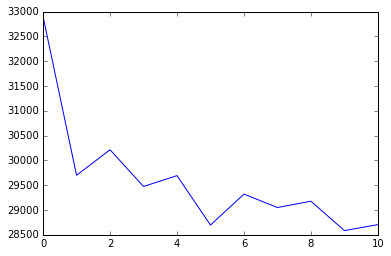

Minimum RMSE: 28584.872636817927 , K-Fold value: 9


In [138]:
%matplotlib inline

x=list(range(0, 11))
plt.plot(x, k_rmses)
plt.show()
min_rmse = min(k_rmses)
min_k = k_rmses.index(min_rmse)
print("Minimum RMSE:", min_rmse, ", K-Fold value:", min_k)